# 1. Importing libraries and Dataset

In [1]:
import pandas as pd 
import numpy as np
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.decomposition import LatentDirichletAllocation,NMF
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from wordcloud import WordCloud

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
data_df=pd.read_csv("nips-papers/papers.csv")

In [4]:
data_df.columns

Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')

In [5]:
data_df['paper_text'].head().apply(len)

0    21643
1    15505
2    20523
3    19441
4    20219
Name: paper_text, dtype: int64

In [6]:
author_name =pd.read_csv('nips-papers/authors.csv')

In [7]:
author_name.head()

,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser


# 2.Text Trocessing

In [8]:
data_df[['title','pdf_name']].head(10)

,title,pdf_name
0,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...
1,A Mean Field Theory of Layer IV of Visual Cort...,10-a-mean-field-theory-of-layer-iv-of-visual-c...
2,Storing Covariance by the Associative Long-Ter...,100-storing-covariance-by-the-associative-long...
3,Bayesian Query Construction for Neural Network...,1000-bayesian-query-construction-for-neural-ne...
4,"Neural Network Ensembles, Cross Validation, an...",1001-neural-network-ensembles-cross-validation...
5,Using a neural net to instantiate a deformable...,1002-using-a-neural-net-to-instantiate-a-defor...
6,Plasticity-Mediated Competitive Learning,1003-plasticity-mediated-competitive-learning.pdf
7,ICEG Morphology Classification using an Analog...,1004-iceg-morphology-classification-using-an-a...
8,Real-Time Control of a Tokamak Plasma Using Ne...,1005-real-time-control-of-a-tokamak-plasma-usi...
9,Pulsestream Synapses with Non-Volatile Analogu...,1006-pulsestream-synapses-with-non-volatile-an...


 * Since title and pdf_name is  same hence removing pdf_name 

In [9]:
data_df['event_type'].unique()

array([nan, 'Oral', 'Spotlight', 'Poster'], dtype=object)

In [10]:
data_df.drop(['pdf_name','event_type'],axis=1,inplace=True)

 * Since our main object is to summarize the text hence and tagging the key words hence we donot require the event type 

In [11]:
data_df.head()

,id,year,title,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [12]:
paper_separate_abstract = data_df[(data_df['abstract']!='Abstract Missing')].index

In [13]:
paper_separate_abstract

Int64Index([ 941, 1067, 2384, 2385, 2388, 2389, 2390, 2393, 2394, 2396,
            ...
            6937, 6938, 6939, 6940, 6941, 6943, 6944, 6945, 6946, 6947],
           dtype='int64', length=3924)

* Since we are processing the text which has an abstract, hence removing the rows which doesnot have abstract 

In [14]:
len(data_df[(data_df['abstract']!='Abstract Missing')].index)

3924

In [15]:
print(data_df['abstract'].iloc[941])

Non-negative matrix factorization (NMF) has previously been shown to 
be a useful decomposition for multivariate data. Two different multi- 
plicative algorithms for NMF are analyzed. They differ only slightly in 
the multiplicative factor used in the update rules. One algorithm can be 
shown to minimize the conventional least squares error while the other 
minimizes the generalized Kullback-Leibler divergence. The monotonic 
convergence of both algorithms can be proven using an auxiliary func- 
tion analogous to that used for proving convergence of the Expectation- 
Maximization algorithm. The algorithms can also be interpreted as diag- 
onally rescaled gradient descent, where the rescaling factor is optimally 
chosen to ensure convergence. 


In [16]:
data_df = data_df.iloc[paper_separate_abstract]

In [17]:
data_df.drop('paper_text',axis=1,inplace=True)

 * Since abstract is present in 3924 text hence removing the full papers of this journals

In [18]:
data_df.reset_index(inplace = True)

In [19]:
data_df.drop('index',axis=1,inplace= True)

In [20]:
print(data_df['abstract'][0])

Non-negative matrix factorization (NMF) has previously been shown to 
be a useful decomposition for multivariate data. Two different multi- 
plicative algorithms for NMF are analyzed. They differ only slightly in 
the multiplicative factor used in the update rules. One algorithm can be 
shown to minimize the conventional least squares error while the other 
minimizes the generalized Kullback-Leibler divergence. The monotonic 
convergence of both algorithms can be proven using an auxiliary func- 
tion analogous to that used for proving convergence of the Expectation- 
Maximization algorithm. The algorithms can also be interpreted as diag- 
onally rescaled gradient descent, where the rescaling factor is optimally 
chosen to ensure convergence. 


 * Counting words before and after text processing 

In [21]:
data_df.head()

,id,year,title,abstract
0,1861,2000,Algorithms for Non-negative Matrix Factorization,Non-negative matrix factorization (NMF) has pr...
1,1975,2001,Characterizing Neural Gain Control using Spike...,Spike-triggered averaging techniques are effec...
2,3163,2007,Competition Adds Complexity,It is known that determinining whether a DEC-P...
3,3164,2007,Efficient Principled Learning of Thin Junction...,We present the first truly polynomial algorith...
4,3167,2007,Regularized Boost for Semi-Supervised Learning,Semi-supervised inductive learning concerns ho...


In [22]:
def text_processing(df,col):
    temp_df = df[col]
    # 1.Remove punctuation
    temp_df = temp_df.apply(lambda x: re.sub('[[^a-zA-Z]]',' ',x))
    # 2. converting lower case
    temp_df = temp_df.apply(lambda x: x.lower())
    # 3. removing special character and digit
    temp_df = temp_df.apply(lambda x: re.sub("(\\d|\\W)+"," ",x))
    return temp_df

In [23]:
data_df['abstract'] =text_processing(data_df,'abstract')

In [24]:
print(data_df['abstract'][0])

non negative matrix factorization nmf has previously been shown to be a useful decomposition for multivariate data two different multi plicative algorithms for nmf are analyzed they differ only slightly in the multiplicative factor used in the update rules one algorithm can be shown to minimize the conventional least squares error while the other minimizes the generalized kullback leibler divergence the monotonic convergence of both algorithms can be proven using an auxiliary func tion analogous to that used for proving convergence of the expectation maximization algorithm the algorithms can also be interpreted as diag onally rescaled gradient descent where the rescaling factor is optimally chosen to ensure convergence 


In [25]:
def tokenize_lemmatize(df,col):
    temp_df =df[col]
    #1. Word Tokenization:
    temp_df = temp_df.apply(lambda x : word_tokenize(x))
    word_no_pre = temp_df.apply(lambda x: len(x))
    temp_df = temp_df.apply(lambda x : [i for i in x if not i in stopwords.words('english')])
    #2. Word Lemmatization:
    lemmatize =WordNetLemmatizer()
    temp_df = temp_df.apply(lambda x: [lemmatize.lemmatize(i) for i in x])
    word_no_post =temp_df.apply(lambda x: len(x))
    temp_df = temp_df.apply(lambda x: " ".join(x))
    return temp_df,word_no_pre,word_no_post

In [26]:
data_df['abstract_post'],data_df['word_count_pre'],data_df['word_count_post']=tokenize_lemmatize(data_df,'abstract')

In [27]:
data_df.head()

,id,year,title,abstract,abstract_post,word_count_pre,word_count_post
0,1861,2000,Algorithms for Non-negative Matrix Factorization,non negative matrix factorization nmf has prev...,non negative matrix factorization nmf previous...,108,67
1,1975,2001,Characterizing Neural Gain Control using Spike...,spike triggered averaging techniques are effec...,spike triggered averaging technique effective ...,83,52
2,3163,2007,Competition Adds Complexity,it is known that determinining whether a dec p...,known determinining whether dec pomdp namely c...,70,40
3,3164,2007,Efficient Principled Learning of Thin Junction...,we present the first truly polynomial algorith...,present first truly polynomial algorithm learn...,144,89
4,3167,2007,Regularized Boost for Semi-Supervised Learning,semi supervised inductive learning concerns ho...,semi supervised inductive learning concern lea...,123,81


# 3. Exploratory Data analysis of the Dataset 

Text(0.5, 0, ' Number of paper published in a year')

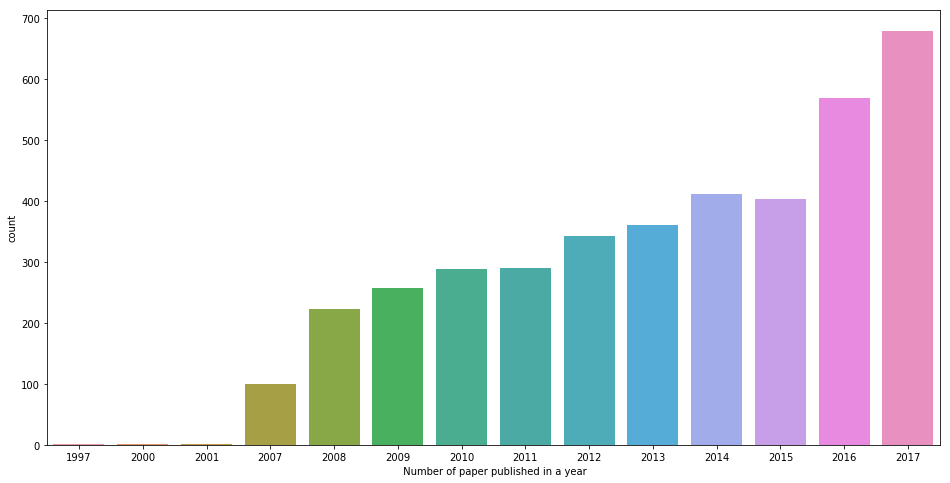

In [28]:
plt.figure(figsize=(16,8))
sns.countplot(x='year',data=data_df)
plt.xlabel(" Number of paper published in a year")

* We can see that  there is a rise of publication of research papers as year increases. 

In [29]:
data_df.columns

Index(['id', 'year', 'title', 'abstract', 'abstract_post', 'word_count_pre',
       'word_count_post'],
      dtype='object')

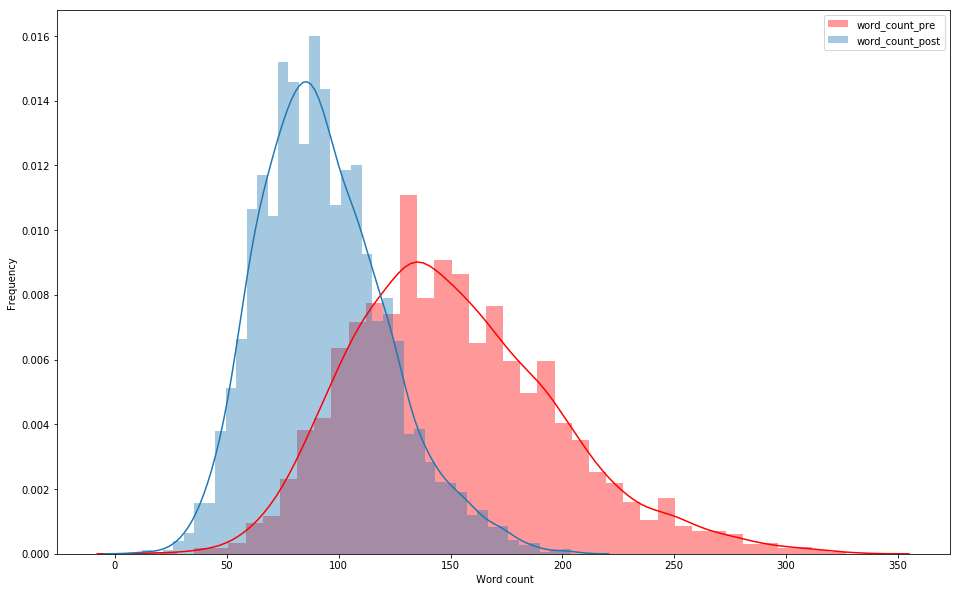

In [30]:
plt.figure(figsize=(16,10))
sns.distplot(data_df['word_count_pre'],color='red')
sns.distplot(data_df['word_count_post'])
plt.xlabel(" Word count")
plt.ylabel('Frequency')
plt.legend(['word_count_pre','word_count_post'],loc='best')

In [31]:
def wordcloud_cluster(data_frame,columns):
    temp_df = list(data_frame[columns])
    cloud = " ".join(temp_df).lower()
    stop_words = set(stopwords.words("english"))
    wordcloud = WordCloud(width = 1600, height = 1200, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    return plt
    

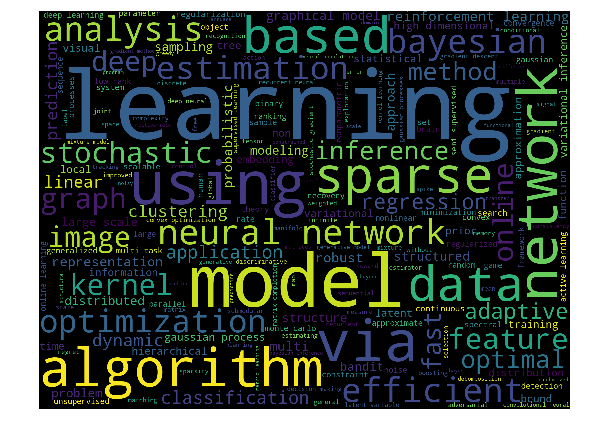

<module 'matplotlib.pyplot' from '/home/anish/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [32]:
wordcloud_cluster(data_df,'title')

* Majority of the words in the title bag of wordss are learning,model,algorithms,bayesian,graph,neural, networks etc 

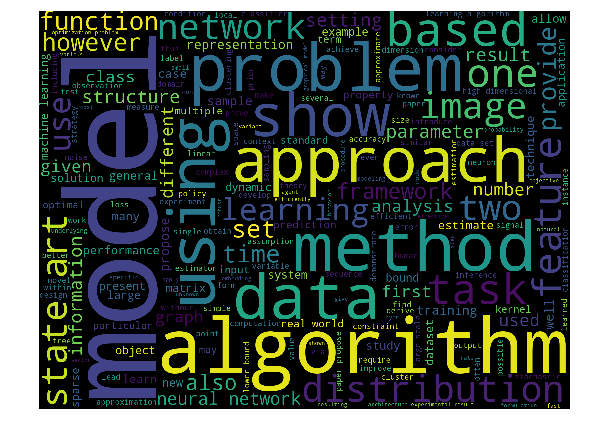

<module 'matplotlib.pyplot' from '/home/anish/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [33]:
wordcloud_cluster(data_df,'abstract_post')

# 4. Gensim Visual  exploration  of clusters and topics

In [34]:
 token_df = data_df['abstract_post'].apply(lambda x:x.split(" "))

In [35]:
# creating word dictionary
dictionary = gensim.corpora.Dictionary(token_df)
#converting dictionary into a bag of words 
word_map =[dictionary.doc2bow(text) for text in token_df]
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=word_map,
                                           id2word=dictionary,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           per_word_topics=True)

In [36]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, word_map, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.096551  0.119806       1        1  29.222599
1     -0.033844 -0.159776       2        1  27.591478
2     -0.232030  0.059157       3        1  22.493319
0      0.169324 -0.019186       4        1  20.692600, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
785   Default  2491.000000        network  2491.000000  30.0000  30.0000
156   Default  4864.000000          model  4864.000000  29.0000  29.0000
80    Default  1214.000000         neural  1214.000000  28.0000  28.0000
323   Default  1106.000000          image  1106.000000  27.0000  27.0000
27    Default  1027.000000         matrix  1027.000000  26.0000  26.0000
0     Default  4097.000000      algorithm  4097.000000  25.0000  25.0000
560   Default  1067.000000          bound  1067.000000  24.0000  24.0000
974   Default   876.000000           deep   876.000000  23.0000  23.0000
146   Default   924.000000      inference   924.000000  22.0000  22.0000
540   Default   725.000000         kernel   725.000000  21.0000  21.0000
595   Default   871.000000          graph   871.000000  20.0000  20.0000
482   Default  3034.000000        problem  3034.000000  19.0000  19.0000
8     Default  3151.000000           data  3151.000000  18.0000  18.0000
633   Default   562.000000      estimator   562.000000  17.0000  17.0000
407   Default  1745.000000       function  1745.000000  16.0000  16.0000
486   Default   497.000000         sparse   497.000000  15.0000  15.0000
1135  Default   605.000000         latent   605.000000  14.0000  14.0000
603   Default   808.000000              n   808.000000  13.0000  13.0000
155   Default  3412.000000       learning  3412.000000  12.0000  12.0000
221   Default  1019.000000   optimization  1019.000000  11.0000  11.0000
755   Default   445.000000     regression   445.000000  10.0000  10.0000
22    Default   966.000000       gradient   966.000000   9.0000   9.0000
77    Default  1010.000000         linear  1010.000000   8.0000   8.0000
233   Default  1471.000000           task  1471.000000   7.0000   7.0000
875   Default   444.000000   architecture   444.000000   6.0000   6.0000
1032  Default   560.000000       bayesian   560.000000   5.0000   5.0000
234   Default  1033.000000       training  1033.000000   4.0000   4.0000
786   Default   767.000000        optimal   767.000000   3.0000   3.0000
1714  Default   524.000000           loss   524.000000   2.0000   2.0000
291   Default   406.000000              x   406.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
4718   Topic4    92.071892     completion    92.792290   1.5676  -6.7106
2493   Topic4   331.801910           rank   346.182831   1.5330  -5.4286
631    Topic4   427.881348    dimensional   535.840942   1.3504  -5.1743
465    Topic4   448.968414     estimation   590.261169   1.3018  -5.1262
690    Topic4   255.972748      dimension   309.458984   1.3856  -5.6881
603    Topic4   557.567871              n   808.160217   1.2042  -4.9095
9      Topic4   168.094971  decomposition   190.016388   1.4528  -6.1086
330    Topic4   354.418732            low   484.462799   1.2628  -5.3627
77     Topic4   629.499146         linear  1010.460510   1.1022  -4.7882
57     Topic4   530.407288       analysis   866.958374   1.0840  -4.9595
539    Topic4   455.221680              k   737.254883   1.0932  -5.1123
844    Topic4   304.020996         vector   441.216125   1.2030  -5.5160
78     Topic4  1176.537354         method  3190.352783   0.5778  -4.1628
441    Topic4   273.308380    statistical   409.288025   1.1716  -5.6225
542    Topic4   259.436951           mean   378.519958   1.1976  -5.6746
320    Topic4   393.357849           high   759.663452   0.9172  -5.2584
482    Topic4   796.346497        problem  3034.625000  

In [37]:
topics = lda_model.show_topics(formatted=False)

In [38]:
topix={}
for i in range(len(topics)):
    val=[]
    print( 'Topic '+str(i))
    for j in range(len(topics[i][1])):
        val.append(topics[i][1][j][0])
    print(val)
    topix['Topic '+str(i)]=val

Topic 0
['method', 'matrix', 'problem', 'data', 'kernel', 'algorithm', 'linear', 'estimator', 'n', 'analysis']
Topic 1
['model', 'data', 'approach', 'learning', 'method', 'algorithm', 'inference', 'graph', 'distribution', 'based']
Topic 2
['network', 'model', 'neural', 'image', 'deep', 'task', 'training', 'learning', 'representation', 'object']
Topic 3
['algorithm', 'learning', 'problem', 'function', 'bound', 'show', 'optimization', 'gradient', 'optimal', 'result']


In [39]:
#len(lda_model[word_map])
len(dictionary)

12641

# 4. LDA paramter tuning, model fitting,keyword clustering 

In [40]:
no_feat =5000
# LDA can only use raw term counts  because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_features=no_feat,stop_words='english')
X_tf = tf_vectorizer.fit_transform(data_df['abstract_post'])
tf_feat_name = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(learning_method='online',random_state=3,n_components=4)
lda_param = {'learning_decay': [0.5,0.6,0.7,0.8,0.9]}
lda_model = GridSearchCV(estimator=lda,param_grid=lda_param)
lda_model.fit(X_tf)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=3, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_decay': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
lda_model.best_params_

{'learning_decay': 0.6}

In [42]:
lda_model.grid_scores_

[mean: -817365.67987, std: 25020.38021, params: {'learning_decay': 0.5},
 mean: -817102.95705, std: 25461.18203, params: {'learning_decay': 0.6},
 mean: -817190.97496, std: 25793.48844, params: {'learning_decay': 0.7},
 mean: -817448.89734, std: 26137.12137, params: {'learning_decay': 0.8},
 mean: -817732.06829, std: 26464.08042, params: {'learning_decay': 0.9}]

In [43]:
best_lda_model = lda_model.best_estimator_

In [44]:
lda_output =best_lda_model.fit_transform(X_tf)

In [45]:
np.argsort(best_lda_model.components_[1])[:-10-1:-1]

array([2855, 1093, 2526, 2784, 2973,  245, 2147, 4534, 1747, 2259])

In [46]:
def visualizing_topic_cluster(model,stop_len,feat_name):
    topic={}
    for index,topix in enumerate(model.components_):
        topic[index]= [feat_name[i] for i in topix.argsort()[:-stop_len-1:-1]]
    
    return topic

In [47]:
dict_topic=visualizing_topic_cluster(best_lda_model,stop_len=10,feat_name=tf_feat_name)

In [48]:
len([print('Topic'+str(key),dict_topic[key]) for key in dict_topic])

Topic0 ['algorithm', 'learning', 'problem', 'policy', 'regret', 'decision', 'model', 'time', 'action', 'online']
Topic1 ['model', 'data', 'learning', 'method', 'network', 'approach', 'image', 'task', 'feature', 'inference']
Topic2 ['algorithm', 'problem', 'method', 'function', 'learning', 'data', 'bound', 'matrix', 'result', 'optimization']
Topic3 ['network', 'model', 'neural', 'neuron', 'time', 'signal', 'data', 'response', 'brain', 'information']


4

# 5. Reccomendation system 

In [49]:
columns=['Topic'+ i for i in list(map(str,list(dict_topic.keys())))]

In [50]:
lda_df = pd.concat(objs=[data_df,pd.DataFrame(lda_output,columns=columns).apply(lambda x : np.round(x,2)),pd.DataFrame([[np.argmax(x),dict_topic[np.argmax(x)]] for x in lda_output],columns=['Major_topic','keywords'])],axis=1)

In [51]:
def rmse_calculation(x,y):
    x,y =x,y
    error=[]
    len_y =len(y)
    for i in range(len_y):
        error.append(np.sqrt(np.power((np.array(x)-np.array(y[i])),2).sum()))
    return error

In [52]:
def reccomendation(df,paper_id,col,keyword):
    paper_1 = df[(df['id']==paper_id)]
    dominant_topic = int(paper_1['Major_topic'])
    paper_2 = df[(df['Major_topic']== dominant_topic)]
    paper_2 = paper_2.drop(paper_1.index)
    x= paper_1[columns].values.tolist()
    y= paper_2[columns].values.tolist()
    error = np.round(rmse_calculation(x,y),2)
    paper_2['error'] = error
    paper_2 = paper_2[['id','title','error']].sort_values('error').head(10)
    title = list(paper_2['title'])
    error = list(paper_2['error'])
#     major_topic = list(paper_2['Major_topic'])
    print(" The title  of selected paper is  :  {}".format(list(paper_1.title)[0]))
    print(" Major Topic --- {}".format(dominant_topic))
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The abstract of the selected topic are as follows : ")
    print("\n",list(paper_1['abstract'])[0])
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The  keywords which is highlighted in this topic are as follows : ")
    [ print(keyword[dominant_topic][i]) for i in range(len(keyword[dominant_topic]))]
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The Recommended topic are as follows: ")
    [print(i+1,"...",title[i],"---","\n","     Error  is ","...",error[i]) for i in range(len(title))]

    print("------------------------------------------------------------------------------------------------------------------------")

# 6.Result: 

In [53]:
reccomendation(lda_df,3219,columns,dict_topic)

 The title  of selected paper is  :  Active Preference Learning with Discrete Choice Data
 Major Topic --- 0
------------------------------------------------------------------------------------------------------------------------
 The abstract of the selected topic are as follows : 

 we propose an active learning algorithm that learns a continuous valuation model from discrete preferences the algorithm automatically decides what items are best presented to an individual in order to find the item that they value highly in as few trials as possible and exploits quirks of human psychology to minimize time and cognitive burden to do this our algorithm maximizes the expected improvement at each query without accurately modelling the entire valuation surface which would be needlessly expensive the problem is particularly difficult because the space of choices is infinite we demonstrate the effectiveness of the new algorithm compared to related active learning methods we also embed the algor

In [54]:
reccomendation(lda_df,3171,columns,dict_topic)

 The title  of selected paper is  :  Mining Internet-Scale Software Repositories
 Major Topic --- 1
------------------------------------------------------------------------------------------------------------------------
 The abstract of the selected topic are as follows : 

 large repositories of source code create new challenges and opportunities for statistical machine learning here we first develop an infrastructure for the automated crawling parsing and database storage of open source software the infrastructure allows us to gather internet scale source code for instance in one experiment we gather java projects from sourceforge and apache totaling over million lines of code from developers simple statistical analyses of the data first reveal robust power law behavior for package sloc and method call distributions we then develop and apply unsupervised author topic probabilistic models to automatically discover the topics embedded in the code and extract topic word and author topi

In [55]:
reccomendation(lda_df,3186,columns,dict_topic)

 The title  of selected paper is  :  Local Algorithms for Approximate Inference in Minor-Excluded Graphs
 Major Topic --- 2
------------------------------------------------------------------------------------------------------------------------
 The abstract of the selected topic are as follows : 

 we present a new local approximation algorithm for computing map and log partition function for arbitrary exponential family distribution represented by a finite valued pair wise markov random field mrf say g our algorithm is based on decomposing g into appropriately chosen small components computing estimates locally in each of these components and then producing a good global solution we prove that the algorithm can provide approximate solution within arbitrary accuracy when g excludes some finite sized graph as its minor and g has bounded degree all planar graphs with bounded degree are examples of such graphs the running time of the algorithm is theta n n is the number of nodes in g wit

In [56]:
reccomendation(lda_df,3213,columns,dict_topic)

 The title  of selected paper is  :  Unconstrained On-line Handwriting Recognition with Recurrent Neural Networks
 Major Topic --- 1
------------------------------------------------------------------------------------------------------------------------
 The abstract of the selected topic are as follows : 

 on line handwriting recognition is unusual among sequence labelling tasks in that the underlying generator of the observed data i e the movement of the pen is recorded directly however the raw data can be difficult to interpret because each letter is spread over many pen locations as a consequence sophisticated pre processing is required to obtain inputs suitable for conventional sequence labelling algorithms such as hmms in this paper we describe a system capable of directly transcribing raw on line handwriting data the system consists of a recurrent neural network trained for sequence labelling combined with a probabilistic language model in experiments on an unconstrained on lin